# EDA of show reviews

The goal of this analysis is to look at the data, get some insights and transform the data if needed. 

## Imports

In [1]:
# !pip install dateparser

In [17]:
import os
import re
import sys
import warnings
from pathlib import Path
from typing import List

import dateparser
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from tqdm import tqdm

tqdm.pandas()


%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from shows_analysis.preprocessing import preprocessor

In [3]:
SEED = 42

## Functions

In [4]:
def normalize_datetime(datetime: str) -> str:
    return dateparser.parse(datetime).strftime("%d.%m.%Y %H:%M")

In [5]:
def return_score(preprocessor, review: str) -> str:
    scores = []
    score = ""
    splitted_review = review.split("<p>")

    # looking only at the last three sentences
    for s in splitted_review[-3:]:
        if preprocessor.has_numbers(s) and (("/" in s) or ("из" in s)):
            scores.append(s)

    # taking only the last match
    score_candidate = (
        BeautifulSoup(scores[-1], "html.parser").get_text() if scores else ""
    )

    # sum of digits in the string - useful, if digits are big
    sum_scores = sum([int(number) for number in re.findall(r"\d+", score_candidate)])

    if (
        scores
        and len(score_candidate.split(" ")) <= 4
        and score_candidate != ""
        and sum_scores < 50
    ):
        score = score_candidate

    score_index = (
        splitted_review.index(scores[-1])
        if scores and scores[-1] in splitted_review
        else None
    )

    return score.strip(), score_index

In [6]:
def clean_reviews_from_scores(reviews: List[str], score_sentence_indices: list):
    cleaned_reviews = []

    for review, score_sentence_index in tqdm(
        zip(reviews, score_sentence_indices),
        total=len(reviews),
        desc="Removing scores from reviews",
    ):
        splitted_review = review.split("<p>")
        if score_sentence_index is not None:
            del splitted_review[score_sentence_index]
        cleaned_reviews.append("<p>".join(splitted_review))

    return cleaned_reviews

In [7]:
def cast_score_to_float(
    score_string: str,
    regex_expression: str = "[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",
) -> float:
    real_numbers = re.findall(regex_expression, score_string)
    real_numbers = [float(number) for number in real_numbers]

    score = real_numbers[0] if len(real_numbers) >= 1 else None

    if score is not None:
        score = 10.0 if score > 10.0 else score
        score = 0.0 if score < 0.0 else score

    return score

## Paths

In [18]:
relative_input_path = os.path.join("../../../../", "data", "1_anonymized_data")

In [19]:
relative_output_path = os.path.join("../../../../", "data", "2_cleaned_reviews")
Path(relative_output_path).mkdir(parents=True, exist_ok=True)

## Data

### Loading data

In [20]:
movie_reviews_df = pd.read_parquet(
    os.path.join(relative_input_path, "movies_reviews.parquet")
)
movie_reviews_df.shape

(171094, 7)

In [21]:
series_reviews_df = pd.read_parquet(
    os.path.join(relative_input_path, "series_reviews.parquet")
)
series_reviews_df.shape

(35643, 7)

### Dataset overview

In [12]:
movie_reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
29900,1965,44279,21 января 2010 19:09,good,,"Юг США, Миссисипи, отличающееся расовым разноо...",16 / 4
154753,977743,49610,12 ноября 2018 00:10,bad,"'Форма воды', Оскар, отношение, размышления, а...",В последний раз я столько хмурила брови и подн...,5 / 3
161478,623250,59545,05 марта 2018 14:59,good,Новая глава любимой саги,Мне хочется сравнить этот фильм с элегантным и...,20 / 39
73900,49166,33188,01 мая 2014 22:18,good,Маскарад абсурда,Для меня мультфильм 'Коралина в Стране Кошмаро...,1 / 1
39455,81733,46751,19 февраля 2009 14:39,bad,Из грязи - в князи?,"Я люблю звенящую прозрачную Киру Найтли, с ее ...",25 / 32
91332,450765,37060,14 марта 2011 18:35,neutral,Любовь не по плану,А вы когда-нибудь задумывались: а что если все...,11 / 7
38957,81733,30715,21 апреля 2018 23:07,good,,Как же приятно смотреть картины где нет ничего...,3 / 7
129787,6144,34494,05 января 2011 13:55,good,,"Пожалуй, один из тех фильмов, которые будут 'в...",7 / 3
79575,705356,36252,22 января 2015 02:06,good,Есть лишь любовь и есть страх,Очень много шумихи поднял совершенно недавно в...,6 / 7
119379,649917,22210,09 октября 2018 09:23,good,"Следуй Обету, данному тобой","Потрясающий фильм о скромном, милом, добром мо...",3 / 0


In [13]:
series_reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,datetime,sentiment,subtitle,review_body,usefulness_ratio
17123,838050,26321,03 апреля 2016 20:22,neutral,А был ли метод?,Вот и я сподобилась посмотреть нашумевший сери...,7 / 6
29947,306084,21093,20 марта 2010 20:23,good,- Почему он не разговаривает? - Ботан же. ©,"Наконец-то я для себя нашел любимый сериал, ко...",57 / 14
14526,1445244,56442,14 сентября 2021 12:51,bad,Первый блин комом,Единственный плюс этого сериала - отличная опе...,65 / 25
8471,453191,68606,26 декабря 2014 18:15,bad,«Санта-Барбара» по-вампирски.,А как неплохо все начиналось… не занудно… акте...,11 / 7
5288,38898,38121,18 июня 2010 00:25,good,,"Вот оттого, что книгу не читал, фильм и не пон...",29 / 17
17419,1331277,7511,19 января 2021 12:13,good,"Если человек обещает что-то, что заведомо не с...",Хорошая фраза и неплохой сериал.<p>Зацепила ид...,12 / 2
1043,401152,6398,11 января 2017 22:28,good,В адаптации телеканала HBO.,Часть первая. <p>Лет пять назад я смотрел сие ...,3 / 4
30271,1209845,38603,13 марта 2021 02:48,good,Достойное продолжение франшизы,Первый фильм был очень популярен. Но к сожален...,14 / 6
33923,502838,60726,20 июня 2015 02:49,neutral,Больше Шерлоков хороших и разных..,Пролог.<p>Этот популярный нынче сериал я посмо...,3 / 6
17767,585100,60714,11 января 2016 15:29,good,,"Изредка я писал рецензии, это большая для меня...",13 / 1


Let's merge datasets

In [14]:
movie_reviews_df.insert(2, "type", "movie")
series_reviews_df.insert(2, "type", "series")

reviews_df = pd.concat([movie_reviews_df, series_reviews_df]).reset_index(drop=True)

In [15]:
reviews_df.sample(n=10, random_state=SEED)

,show_id,user_id,type,datetime,sentiment,subtitle,review_body,usefulness_ratio
196236,257386,28525,series,27 августа 2010 11:23,good,Вечный город.,К истории Древнего мира у меня отношение особо...,50 / 10
128582,688832,44953,movie,20 февраля 2015 23:19,bad,50 оттенков разочарования,"Говорю сразу, книги читала все, да и по нескол...",11 / 6
159673,349,33910,movie,15 апреля 2018 21:04,good,"Господи, спасибо, что не пронесло мимо","Есть два типа фильмов, мой друг. Одни ты прост...",5 / 1
109244,686898,44065,movie,11 сентября 2019 11:58,neutral,Что же стало с клоуном?,"Итак, в первую очередь хотелось бы отметить то...",5 / 3
92610,61455,66782,movie,27 ноября 2017 18:52,good,Они отказываются подчиняться,"Автора этого замечательного фильма, Джосса Уэд...",5 / 0
43727,491724,44563,movie,28 января 2012 23:18,good,Жестокая правда,"Финчер снова нас поразил, он всегда нас поража...",18 / 11
50195,102130,67145,movie,17 августа 2009 11:56,good,"Преодолеть 2 года жизни, что встретиться","Слышал о фильме много, и в основном положитель...",14 / 3
43651,491724,66283,movie,19 февраля 2012 15:33,bad,"Мужчины, которые ненавидели женщин.",Я попробовала рассматривать этот фильм с двух ...,20 / 17
48775,7226,7905,movie,20 февраля 2014 03:44,good,,"«Догвилль» - это один из тех редких фильмов, п...",5 / 2
75262,458,33255,movie,22 июня 2013 21:14,good,Тайна закрытой двери,Я имела счастье смотреть этот мультфильм в кин...,6 / 0


### Dataset Close Look

In this section, let's look at what columns we have, what type they are, how many non-zero values, etc.

But before, let's replace empty strings with NaN values.

In [16]:
reviews_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)

In [17]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   show_id           206737 non-null  int64 
 1   user_id           206737 non-null  int64 
 2   type              206737 non-null  object
 3   datetime          206737 non-null  object
 4   sentiment         206737 non-null  object
 5   subtitle          173836 non-null  object
 6   review_body       206737 non-null  object
 7   usefulness_ratio  206737 non-null  object
dtypes: int64(2), object(6)
memory usage: 12.6+ MB


As we can see, `subtitle` is empty sometimes.

### Memory optimization

Also, we should better be treating `sentiment` and `type` columns as categorical.  
One of the benefits of such transformation is the dataset will be more efficiently stored.

In [18]:
reviews_df[["type", "sentiment"]] = reviews_df[["type", "sentiment"]].astype("category")

In [19]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   show_id           206737 non-null  int64   
 1   user_id           206737 non-null  int64   
 2   type              206737 non-null  category
 3   datetime          206737 non-null  object  
 4   sentiment         206737 non-null  category
 5   subtitle          173836 non-null  object  
 6   review_body       206737 non-null  object  
 7   usefulness_ratio  206737 non-null  object  
dtypes: category(2), int64(2), object(4)
memory usage: 9.9+ MB


We've just saved about 2.7 MB out of 12.6 MB (around 20%), which isn't bad for a one line of code.

## Tasks

Based on this look I've determined some things to do:
* Look at the columns, determine the number of unique values, duplicates, etc.
* **[+]** Normalize `datetime` column 
* **[+]** Calculate `usefulness_ratio` based on the format `likes / dislikes`
* **[+]** Extract user scores from reviews

## EDA

### `datetime`

#### Transformation

Currently, datetime looks like this:

In [20]:
reviews_df["datetime"][0]

'16 февраля 2022 11:21'

I could create map with months manually, replace month for every date and then change the format, but I will use `dateparser` package 

In [21]:
dateparser.parse(reviews_df["datetime"][0]).strftime("%d.%m.%Y %H:%M")

C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


'16.02.2022 11:21'

In [22]:
reviews_df["datetime_casted"] = reviews_df["datetime"].progress_apply(
    normalize_datetime
)
reviews_df["datetime_casted"] = pd.to_datetime(reviews_df["datetime_casted"])

100%|█████████████████████████████████████████████████████████████████████████| 206737/206737 [05:04<00:00, 678.11it/s]


Now we can extract valuable information from the `datetime` column

#### Analysis

`datetime` column represents date and time when the review was published.

##### Hour distribution

Let's look at hour distribution

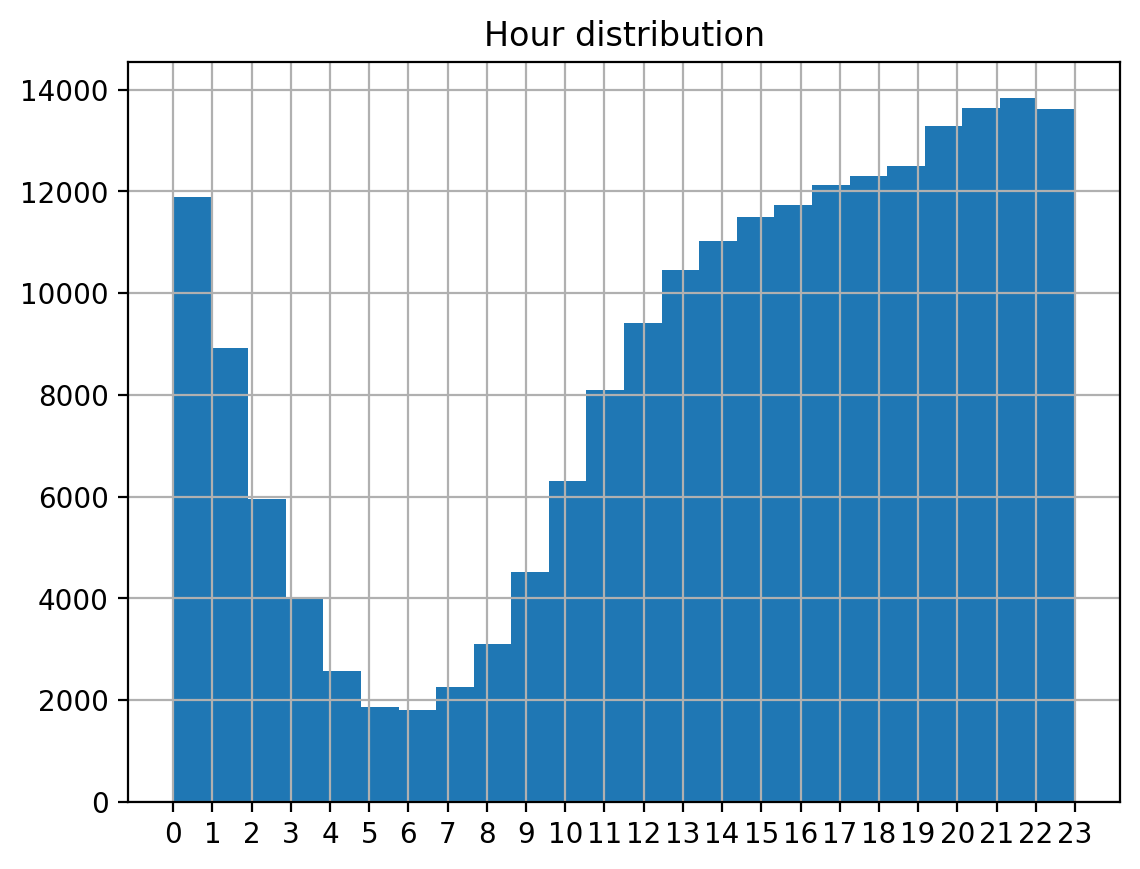

In [23]:
ax = reviews_df["datetime_casted"].dt.hour.hist(bins=24)
ax.set_xticks(range(0, 24), minor=False)
ax.set(title="Hour distribution");

People tend to publish reviews the later the more often with absolute maximum around 20-23 o'clock in the evening and absolute minimum around 4-7 o'clock in the morning.

##### Weekday distribution

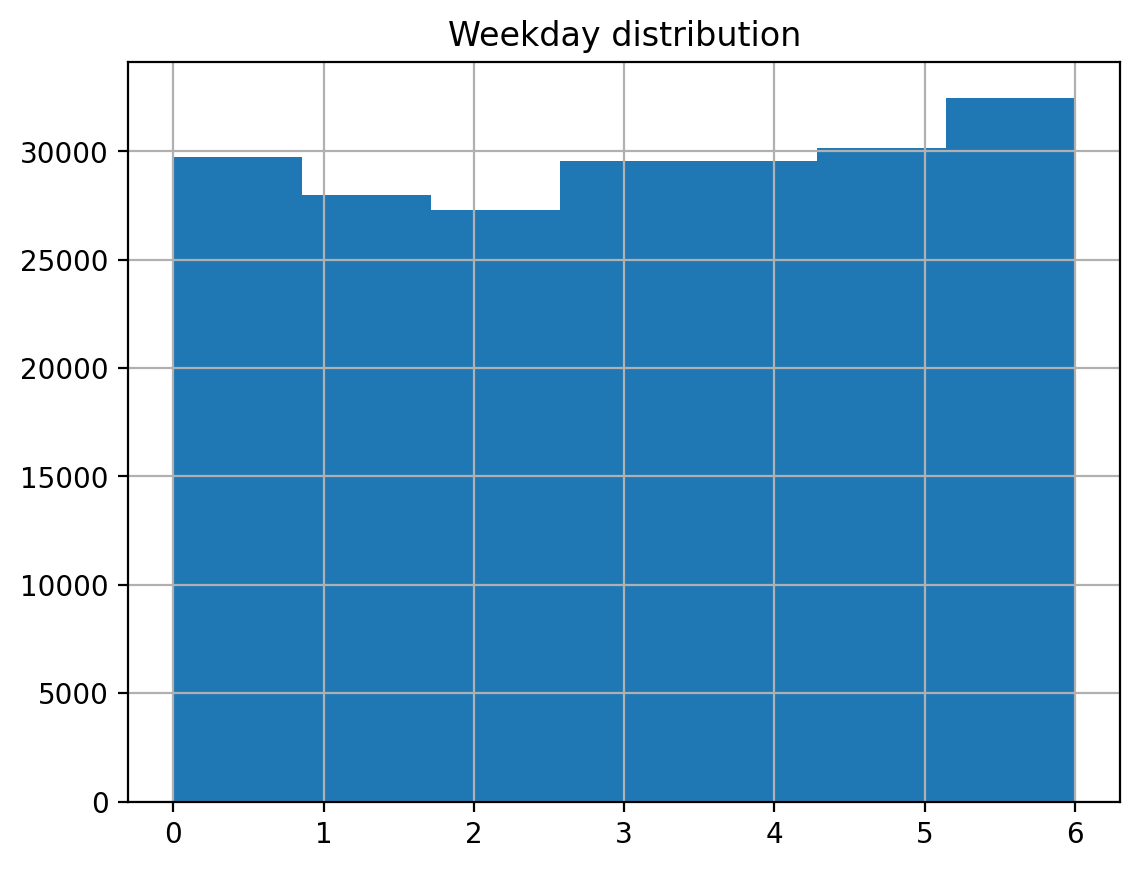

In [24]:
ax = reviews_df["datetime_casted"].dt.weekday.hist(bins=7)
ax.set_xticks(range(0, 7), minor=False)
ax.set(title="Weekday distribution");

People tend to publish more reviews on Sundays, but between Mondays, Thursdays, Fridays and Saturdays the difference is not that significant

##### Month distribution

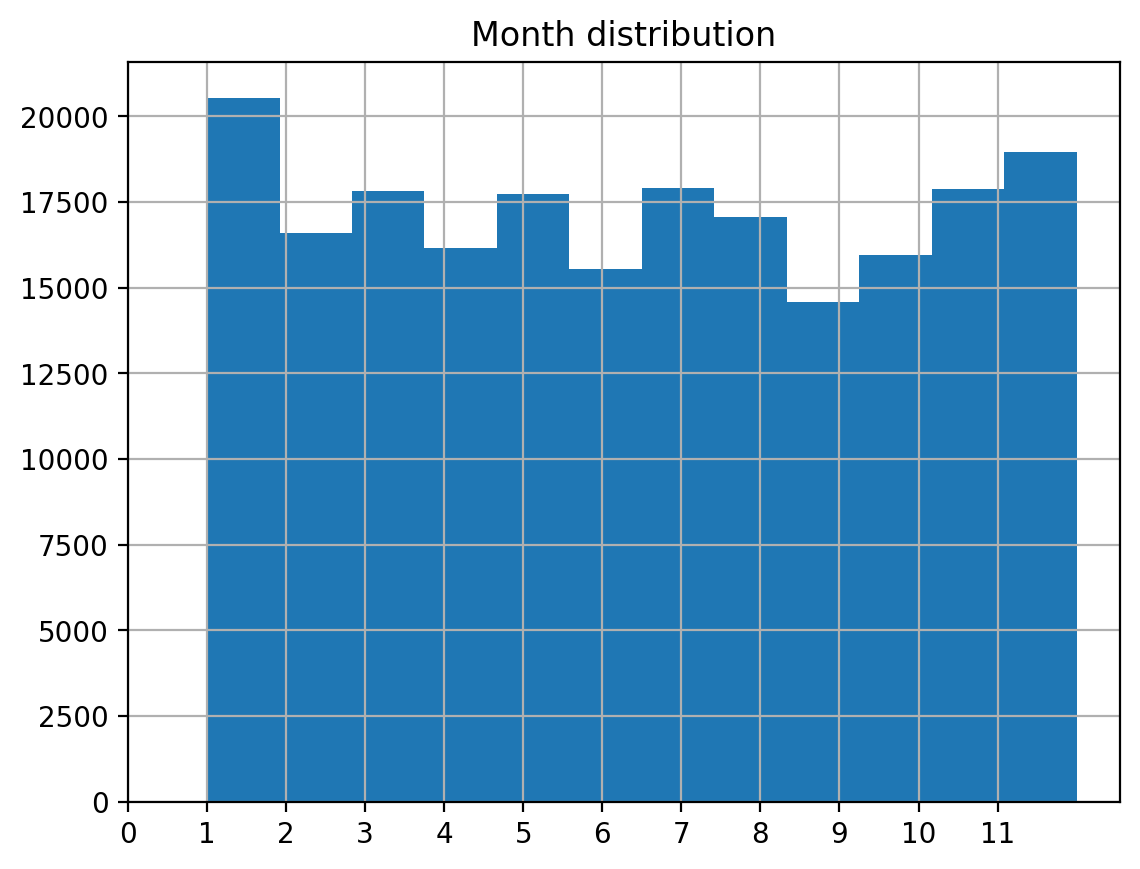

In [25]:
ax = reviews_df["datetime_casted"].dt.month.hist(bins=12)
ax.set_xticks(range(0, 12), minor=False)
ax.set(title="Month distribution");

People tend to publish more reviews on winter months (especially on January). It can be caused by the number of holidays in Russia on January and, also, generally correlated with cold weather.

### `usefulness_ratio`

#### Transformation

Currently, `usefulness_ratio` looks like this:

In [26]:
reviews_df["usefulness_ratio"].sample(10, random_state=SEED)

196236    50 / 10
128582     11 / 6
159673      5 / 1
109244      5 / 3
92610       5 / 0
43727     18 / 11
50195      14 / 3
43651     20 / 17
48775       5 / 2
75262       6 / 0
Name: usefulness_ratio, dtype: object

We can replace `/` with `-` and then evaluate expression to get difference between likes and dislikes for the review. Let's do this.

In [27]:
reviews_df["usefulness_ratio_transformed"] = (
    reviews_df["usefulness_ratio"].replace(" / ", "-", regex=True).progress_apply(eval)
)

100%|██████████████████████████████████████████████████████████████████████| 206737/206737 [00:01<00:00, 171822.63it/s]


#### Analysis

In [28]:
reviews_df["usefulness_ratio_transformed"].describe()

count    206737.000000
mean          3.836236
std          67.719842
min       -9332.000000
25%          -1.000000
50%           4.000000
75%          12.000000
max        4921.000000
Name: usefulness_ratio_transformed, dtype: float64

We have some pretty big outliers

In [29]:
reviews_df["usefulness_ratio_transformed"].value_counts()[:20]

 1     11029
 2     10779
 0     10237
 3     10222
 4      9402
 5      8611
-1      7690
 6      7385
 7      6803
 8      6180
-2      6031
 9      5675
 10     5091
 11     4849
-3      4609
 12     4190
-4      3936
 13     3826
 14     3428
-5      3184
Name: usefulness_ratio_transformed, dtype: int64

In [30]:
usefulness = reviews_df["usefulness_ratio_transformed"]

In [31]:
usefulness.quantile(0.05), usefulness.quantile(0.95)

(-29.0, 41.0)

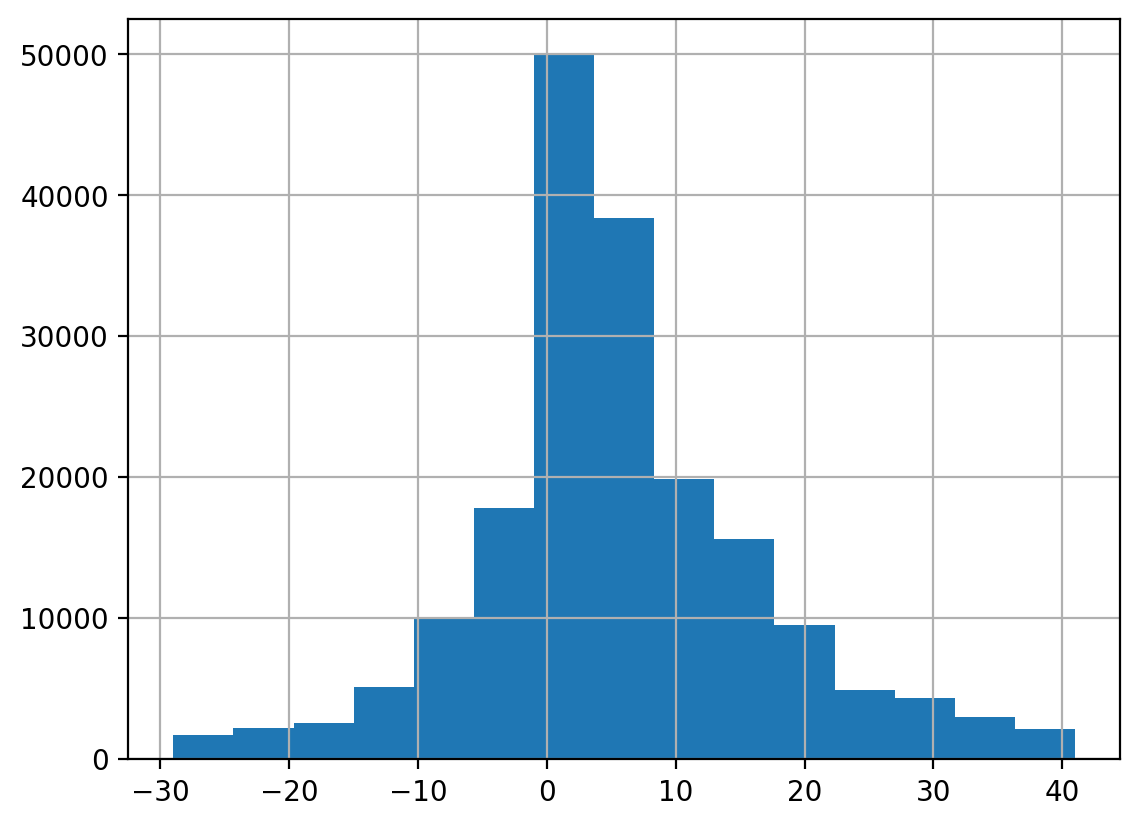

In [32]:
usefulness[
    (usefulness >= usefulness.quantile(0.05))
    & (usefulness <= usefulness.quantile(0.95))
].hist(bins=15);

We can see that reviews are usually not very useful, but the are more useful ones.

### `review_body`

Some reviews have user's score in them. The scores located inside the review (usually, at the end).  
Firstly, we need to extract the scores (we can use them as an additional feature), then we need to remove them from the reviews, so they won't spoil the generalisation ability of classifier.

Empirically, the next basic approach was developed. 

#### Transformation

##### Getting scores

In [33]:
prep = preprocessor.Preprocessor()

In [34]:
scores_and_indices = [
    return_score(prep, review) for review in tqdm(reviews_df["review_body"].values)
]

  3%|██▌                                                                      | 7174/206737 [00:00<00:13, 14807.32it/s]C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.agvaya.ru/?p=721#more-721" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
 95%|███████████████████████████████████████████████████████████████████▋   | 196934/206737 [00:11<00:00, 17073.42it/s]C:\Users\ryblo\Documents\projects\movie_reviews\venv\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.kinopoisk.ru/user/5016861/comment/2221734/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
100%|████████

In [35]:
scores, score_sentence_indices = list(map(list, zip(*scores_and_indices)))

In [36]:
reviews_df["scores"] = scores

##### Cleaning reviews from scores

In [37]:
reviews = reviews_df["review_body"].values.tolist()

In [38]:
assert len(score_sentence_indices) == len(reviews)

In [39]:
reviews_df["review_body_cleaned"] = clean_reviews_from_scores(
    reviews, score_sentence_indices
)

Removing scores from reviews: 100%|████████████████████████████████████████| 206737/206737 [00:01<00:00, 205539.77it/s]


#### Analysis

In [40]:
counts = reviews_df["scores"].value_counts(ascending=False)

In [41]:
counts

                         77393
10 из 10                 47471
9 из 10                  20137
8 из 10                  18247
7 из 10                  12255
                         ...  
10 из 10, ОДНОЗНАЧНО!        1
10 из 10 возможных           1
3,7 из 10                    1
10 из 10, безусловно         1
Вердикт: 7 из 10.            1
Name: scores, Length: 1038, dtype: int64

As we can see, for the 77 393 reviews we haven't find scores in the review.

### `scores`

#### Transformation

##### Cleaning

Firstly, let's replace commas with dots

In [42]:
reviews_df["scores"] = reviews_df["scores"].str.replace(",", ".")

And then we will further clean the scores

In [43]:
reviews_df["scores"] = (
    reviews_df["scores"]
    .str.replace("!", ".")
    .str.replace("+", "")
    .str.replace("из", "/")
    .str.rstrip(".")
    .str.lstrip(".")
    .str.rstrip("…")
    .str.replace(" / ", "/")
    .str.replace(" /", "/")
    .str.replace("/ ", "/")
    .str.replace("//", "/")
)

C:\Users\ryblo\AppData\Local\Temp\ipykernel_8416\646544203.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  reviews_df["scores"]


##### Casting scores to real numbers

In [44]:
reviews_df["scores_cleaned"] = reviews_df["scores"].progress_apply(
    lambda score: cast_score_to_float(score)
)

100%|██████████████████████████████████████████████████████████████████████| 206737/206737 [00:00<00:00, 438620.59it/s]


#### Analysis

<AxesSubplot:>

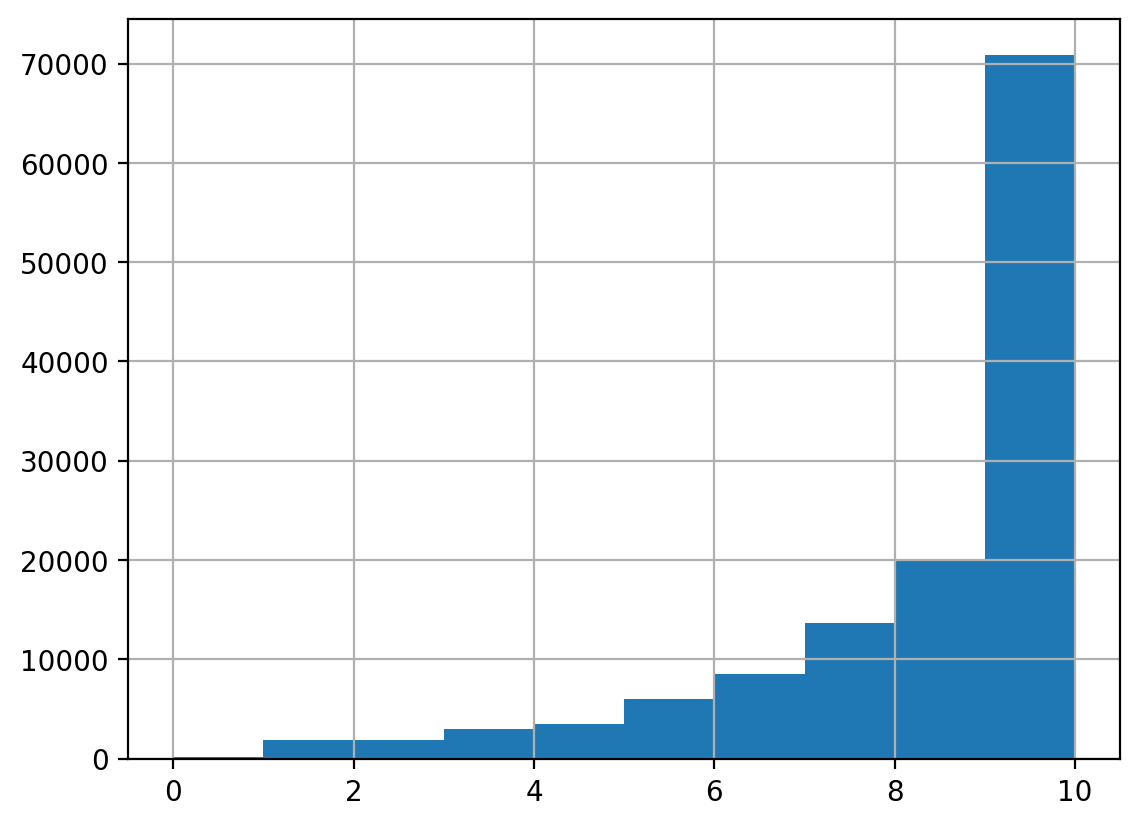

In [45]:
reviews_df["scores_cleaned"].hist(bins=10)

In [46]:
reviews_df.columns

Index(['show_id', 'user_id', 'type', 'datetime', 'sentiment', 'subtitle',
       'review_body', 'usefulness_ratio', 'datetime_casted',
       'usefulness_ratio_transformed', 'scores', 'review_body_cleaned',
       'scores_cleaned'],
      dtype='object')

Users tend to give a high score in their reviews.

## Saving merged and transformed dataset

In [47]:
columns = [
    "show_id",
    "user_id",
    "type",
    "datetime_casted",
    "sentiment",
    "subtitle",
    "review_body_cleaned",
    "usefulness_ratio_transformed",
    "scores_cleaned",
]

final_reviews_df = reviews_df[columns].rename(
    columns={
        "datetime_casted": "datetime",
        "review_body_cleaned": "review",
        "scores_cleaned": "score",
        "usefulness_ratio_transformed": "review_usefulness",
    }
)

In [48]:
final_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206737 entries, 0 to 206736
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   show_id            206737 non-null  int64         
 1   user_id            206737 non-null  int64         
 2   type               206737 non-null  category      
 3   datetime           206737 non-null  datetime64[ns]
 4   sentiment          206737 non-null  category      
 5   subtitle           173836 non-null  object        
 6   review             206737 non-null  object        
 7   review_usefulness  206737 non-null  int64         
 8   score              129344 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 11.4+ MB


In [50]:
final_reviews_df.to_parquet(os.path.join(relative_output_path, "reviews.parquet"))